# Project Implementation

## Install and import the required libraries

<br>
In the implementation part, we will start by importing the required libraries for our work. We will work mainly with yfinance for data collection, Pandas and Numpy for data processing, and TensorFlow for machine learning.

<br>
Other relevant libraries are keras_tuner for hyperparameter optimization, scikit-learn for data scaling and model evaluation, pandas-ta for calculating technical indicators based on the data from yfinance, and matplotlib for visualization.

In [1]:
# install Dependencies and import libraries
# !pip install yfinance pandas numpy tensorflow scikit-learn pandas-ta matplotlib

In [65]:
# https://pypi.org/project/yfinance/ (""" it's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes. """)
# import yfinance, our data source
import yfinance as yf

# import pandas and numpy
import pandas as pd 
import numpy as np

# import from tensorflow
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Input, GRU, SeparableConv1D, BatchNormalization, MaxPooling1D, add, Layer, concatenate
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.saving import register_keras_serializable

# import from keras_tuner
from keras_tuner import HyperModel, Hyperband, Tuner, Oracle

# import from scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, r2_score, confusion_matrix, ConfusionMatrixDisplay

# https://pypi.org/project/pandas-ta/ ("""An easy to use Python 3 Pandas Extension with 130+ Technical Analysis Indicators. Can be called from a Pandas DataFrame or standalone""")
# import pandas-ta
import pandas_ta as ta

# import matplotlib for data visualisation
import matplotlib.pyplot as plt

# this library allow us to calculate how long a process would take 
from datetime import datetime

## Load Data


<br>
In this implementation, we will work with 5 different stocks from the S&P500(1) list. The 5 stocks we will work with are chosen based on their ranking in this list from most valuable to least valuable, and each one is relatively distant from the other and belongs to a different industry. This will ensure a diverse sample and that our model evaluation results generalize relatively well, reducing the possibility of bias and overfitting.

Check out our stock list for this project (2).

<br>
The yfinance API allows us to request the stock data for a company's given period and interval values. For the period value, we will set it to 10 years or max value which will be sufficient for all of our experiments, for the interval value however, which determines the frequency of the data rows, we will experiment with many options to see if our approach generalizes better with specific interval values as different intervals are relevant to other groups of financial analysts and traders in the real world, therefore we must try to create the best model relevant to each of these groups.

That's why we will define a function that allows us to download any number of stock data at any period or interval, save the data as a CSV file to local storage, load it from storage, split it into different data frames based on the stock, and organize the data frames in a dictionary so it's easy to work with for the rest of the project.

Check out the loadData function (3).

In [3]:
# insert the stock symbols into a list
symbols_list = ['PFE', 'ROP', 'XYL', 'CPAY', 'INCY']

In [4]:
# define a function to load the data from source (yfinance API), and save it as a csv to local storage
def loadData(symbols=symbols_list, period='10y', interval='1wk'):
    
    try:
        # load the the dataframe from the csv file if it already exist
        df = pd.read_csv(f'{period}_{interval}_stocks_data.csv').set_index(['Date', 'Ticker'])
        
        print("Data loaded from directory")
        
    except FileNotFoundError:
        # print a message stating the data does not already exists and need to be downloaded from yfinance
        print(f"There is no {period}_{interval}_stocks_data.csv. Data will be downloaded from yfinance.")
        
        # download the data from source and store it in the stock_data variable which will hold the data as a pandas dataframe
        stocks_data =  yf.download(symbols, period=period, interval=interval)

        # reshape the dataframe as a multi-level index dataframe
        stocks_data = stocks_data.stack()

        # source: https://www.statology.org/pandas-change-column-names-to-lowercase/
        # convert column names to lowercase
        stocks_data.columns = stocks_data.columns.str.lower()

        # save the dataframe to a csv file (Save the data to a CSV so we don't have to make any extra unnecessary requests to the API every time we reload the notebook)
        stocks_data.to_csv(f'{period}_{interval}_stocks_data.csv', index=True)

        # load the the dataframe from the csv file
        df = pd.read_csv(f'{period}_{interval}_stocks_data.csv').set_index(['Date', 'Ticker'])

    finally: 
        # create a dict to store the dataframe of each unique symbol where keys are symbol, values are dataframes
        df_dict = {}

        # iterate over the symbols
        for symbol in symbols:

            # source of inspiration https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html [11]
            # extract the specific stock data at the 'Ticker' level of this multi index dataframe and save it as a dataframe
            symbol_df = df.xs(symbol, axis=0, level='Ticker', drop_level=True)

            # store the datafram into the df_dict
            df_dict[symbol] = symbol_df

        # return the dictionary
        return df_dict

Load the data of the 5 selected stocks for the last 10 years on a weekly intrevals.

In [5]:
# load the stock data for the 5 companies into a dictionary
dfs = loadData(symbols=symbols_list, period='10y', interval='1wk')

Data loaded from directory


## Perform simple exploritory data analysis

<br> 
Now that we have a dictionary of dataframes, we can analyze the data and make some observations.

1. We can get the shape of the data for any stock

In [6]:
# the data shape
for symbol in dfs.keys():
    print(f"Symbol: {symbol}, Shape: {dfs[symbol].shape} ")

Symbol: PFE, Shape: (523, 6) 
Symbol: ROP, Shape: (523, 6) 
Symbol: XYL, Shape: (523, 6) 
Symbol: CPAY, Shape: (523, 6) 
Symbol: INCY, Shape: (523, 6) 


2. We can get the basic stats for any stock

In [7]:
# data basic stats
dfs["PFE"].describe()

,adj close,close,high,low,open,volume
count,523.000000,523.000000,523.000000,523.000000,523.000000,5.230000e+02
mean,29.870774,36.269160,37.066481,35.423588,36.250718,1.373323e+08
std,7.594988,6.862873,7.114429,6.536369,6.851178,6.265050e+07
min,17.923565,25.400000,26.170000,25.200001,25.580000,3.922725e+07
25%,23.773307,31.555978,32.129982,30.858634,31.555977,9.714320e+07
50%,28.344492,34.478176,34.914612,33.785580,34.487667,1.215046e+08
75%,33.093800,40.028976,40.682581,39.165085,40.033976,1.583856e+08
max,52.740730,59.480000,61.709999,57.160000,60.599998,6.333997e+08


3. We can check how many missing values each column have for a any stock dataframe

In [8]:
# how many null values in each column
dfs['PFE'].isnull().sum()

adj close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

#### Columns breakdown

<br>
Date: The index is the date on which the information on the rest of the columns takes place.

<br>
Adjusted close: is the closing price after adjustments for all applicable splits and dividend distributions which represents the true closing price.

<br>
Close: is the historical closing price of the stock.

<br>
High: is the highest point a stock has reached.

<br>
Low: is the lowest point of a stock.

<br>
Open: the opening price of the stock.

<br>
Volume: the volume of stocks traded in that timeframe.

<br>
Usually for this type of model we would only keep either Adjusted close or close, we are going to keep the adjusted close for now but it worth mentiong that most of the technical indicators we are utilizing are dependent on the none adjusted close.

## Adding Targets

<br>
To predict stock trends based on past data, we'll create two new columns:

- 'next_close': Represents the next closing price, serving as the target for the regression model.

- 'trend': Indicates whether the next close is higher '1' or lower '0' than the current close, serving as the target for the classification model.

So we will train the model on to the current closing price and make it predict the next closing price/trend for any given timestep.

<br>
To do that we define the add_targets(4) function which takes a data frame as input, adds the 'next_close' and 'trend' columns to it, and returns it as an output.

In [9]:
# create a function that takes a dataframe and create 'next_close' column based on its 'close' column
def get_next_close(_df):
    
    # create the 'next_close' column to be equal to the next closing price
    # this can be accomplished easily by shifting the close column backward by 1
    return _df['close'].shift(-1)

# create a function that returns 1 if the the next closing price is higher than current closing price and 0 otherwise.
def assign_trend(row):
    if row['next_close'] > row['close']:
        return 1
    elif row['next_close'] < row['close']:
        return 0
    else: # if the next value is missing then return NaN
        return np.nan

# create a function that add the target columns to the dataframe
def add_targets(_df):
    
    # add the next_close column to the dataframe
    _df['next_close'] = get_next_close(_df)
    
    # add the trend column to the dataframe
    _df['trend'] = _df.apply(assign_trend, axis=1)
    
    # drop the NaN values
    _df.dropna(inplace=True)
    
    # fix the 'trend' data type to be int
    _df = _df.astype({'trend': int})
    
    return _df

## Feature Engineering

<br>
Adding indicators to the dataframe is important for enhancing model performance and accuracy.

<br>
We can either manually calculate technical indicators, which is time-consuming and prone to errors, or we can utilize an existing library designed for this purpose. pandas-ta is a library that includes a wide set of technical indicators and is designed to work seamlessly with pandas dataframes.

To explore the available indicators in pandas-ta, you can use the following:

In [10]:
# list available technical indicators
help(dfs['PFE'].ta.indicators())

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

For this project, we added a total of 66 technical indicators. Each feature is carefully selected based on the technical indicator's definition and description. 

Check the full list of the selected indicators and the implementation of the add_technical_indicators function which take a dataframe as input and add these indicators to it (5).

We can also get detailed information on specific indicators:

In [11]:
# examine the MACD indicator
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

Then, we’ll group the features into four categories:
1. Base Features: Original features from yfinance (6 features).
2. Technical Indicators based on Closing Price: (30 features).
3. Technical Indicators based on Highs and Lows: (31 features).
4. Technical Indicators based on Volume: (5 features).
This grouping will enable us to create more sophisticated models, such as multi-output or inception models, which we will explore later.

In [12]:
# for the time being let's create a function that add all the technical indicators we want to a df
def add_technical_indicators(_df):
    
    ##### indicators based on the closing price ##### index range: 6:36
    # apply macd on the close column in a df and add it to the dataframe    
    macd = ta.macd(_df['close'])
    # The MACD (Moving Average Convergence/Divergence) is a popular indicator to that is used to identify a trend
    _df.insert(6, 'macd', macd.iloc[:,0])
    # Histogram is the difference of MACD and Signal
    _df.insert(7, 'macd_histogram', macd.iloc[:,1])
    # Signal is an EMA (exponential moving average) of MACD
    _df.insert(8, 'macd_signal', macd.iloc[:,2])
    
    # apply RSI on the Close column in a df and add it to the dataframe    
    # RSI (Relative Strength Index) is popular momentum oscillator. Measures velocity and magnitude a trend
    rsi = ta.rsi(_df['close'])
    _df.insert(9, 'rsi', rsi)

    # apply SMA on the Close column in a df and add it to the dataframe    
    # SMA (Simple Moving Average) is the classic moving average that is the equally weighted average over n periods.
    sma = ta.sma(_df['close'])
    _df.insert(10, 'sma', sma)

    # apply EMA on the Close column in a df and add it to the dataframe    
    # EMA (Exponential Moving Average). The weights are determined by alpha which is proportional to it's length.
    ema = ta.ema(_df['close'])
    _df.insert(11, 'ema', ema)
    
    ######## repeat the same proccess for all the technical indicators we want to include ##########
    # bbands: A popular volatility indicator by John Bollinger.
    bbands = ta.bbands(_df['close'])
    _df.insert(12, 'bbands_lower', bbands.iloc[:,0])
    _df.insert(13, 'bbands_mid', bbands.iloc[:,1])
    _df.insert(14, 'bbands_upper', bbands.iloc[:,2])
    _df.insert(15, 'bbands_bandwidth', bbands.iloc[:,3])
    _df.insert(16, 'bbands_percent', bbands.iloc[:,4])
    
    # dema: The Double Exponential Moving Average attempts to a smoother average with less lag than the normal Exponential Moving Average (EMA).
    dema = ta.dema(_df['close'])
    _df.insert(17, 'dema', dema)
    
    # tema: A less laggy Exponential Moving Average.
    tema = ta.tema(_df['close'])
    _df.insert(18, 'tema', tema)

    # roc: Rate of Change is an indicator is also referred to as Momentum. It is a pure momentum oscillator that measures the percent change in price with the previous price 'n' (or length) periods ago.
    roc = ta.roc(_df['close'])
    _df.insert(19, 'roc', roc)
    
    # mom: Momentum is an indicator used to measure a security's speed (or strength) of movement.  Or simply the change in price.
    mom = ta.mom(_df['close'])
    _df.insert(20, 'mom', mom)
    
    # kama: Developed by Perry Kaufman, Kaufman's Adaptive Moving Average (KAMA) is a moving average designed to account for market noise or volatility. KAMA will closely follow prices when the price swings are relatively small and the noise is low. KAMA will adjust when the price swings widen and follow prices from a greater distance. This trend-following indicator can be used to identify the overall trend, time turning points and filter price movements.
    kama = ta.kama(_df['close'])
    _df.insert(21, 'kama', kama)
                       
    # trix: is a momentum oscillator to identify divergences.
    trix = ta.trix(_df['close'])
    _df.insert(22, 'trix', trix.iloc[:,0])
    _df.insert(23, 'trixs', trix.iloc[:,1])
    
    # hma: The Hull Exponential Moving Average attempts to reduce or remove lag in moving averages.
    hma = ta.hma(_df['close'])
    _df.insert(24, 'hma', hma)
    
    # alma: The ALMA moving average uses the curve of the Normal (Gauss) distribution, which can be shifted from 0 to 1. This allows regulating the smoothness and high sensitivity of the indicator. Sigma is another parameter that is responsible for the shape of the curve coefficients. This moving average reduces lag of the data in conjunction with smoothing to reduce noise.
    alma = ta.alma(_df['close'])
    _df.insert(25, 'alma', alma)
    
    # apo: The Absolute Price Oscillator is an indicator used to measure a security's momentum.  It is simply the difference of two Exponential Moving Averages (EMA) of two different periods. Note: APO and MACD lines are equivalent.
    apo = ta.apo(_df['close'])
    _df.insert(26, 'apo', apo)
    
    # cfo: The Forecast Oscillator calculates the percentage difference between the actualprice and the Time Series Forecast (the endpoint of a linear regression line).
    cfo = ta.cfo(_df['close'])
    _df.insert(27, 'cfo', cfo)
    
    # cg: The Center of Gravity Indicator by John Ehlers attempts to identify turning points while exhibiting zero lag and smoothing.
    cg = ta.cg(_df['close'])
    _df.insert(28, 'cg', cg)
    
    # cmo: Attempts to capture the momentum of an asset with overbought at 50 and oversold at -50.
    cmo = ta.cmo(_df['close'])
    _df.insert(29, 'cmo', cmo)
    
    # coppock: Coppock Curve (originally called the "Trendex Model") is a momentum indicator is designed for use on a monthly time scale.  Although designed for monthly use, a daily calculation over the same period can be made, converting the periods to 294-day and 231-day rate of changes, and a 210-day weighted moving average.
    coppock = ta.coppock(_df['close'])
    _df.insert(30, 'coppock', coppock)
    
    # cti: The Correlation Trend Indicator is an oscillator created by John Ehler in 2020. It assigns a value depending on how close prices in that range are to following a positively- or negatively-sloping straight line. Values range from -1 to 1. This is a wrapper for ta.linreg(close, r=True).
    cti = ta.cti(_df['close'])
    _df.insert(31, 'cti', cti)
    
    # decay: Creates a decay moving forward from prior signals like crosses. The default is "linear". Exponential is optional as "exponential" or "exp".
    decay = ta.decay(_df['close'])
    _df.insert(32, 'decay', decay)
    
    # decreasing: Returns True if the series is decreasing over a period, False otherwise. If the kwarg 'strict' is True, it returns True if it is continuously decreasing over the period. When using the kwarg 'asint', then it returns 1 for True or 0 for False.
    decreasing = ta.decreasing(_df['close'])
    _df.insert(33, 'decreasing', decreasing)
    
    # ebsw: This indicator measures market cycles and uses a low pass filter to remove noise. Its output is bound signal between -1 and 1 and the maximum length of a detected trend is limited by its length input.
    ebsw = ta.ebsw(_df['close'])
    _df.insert(34, 'ebsw', ebsw)
    
    # entropy: Introduced by Claude Shannon in 1948, entropy measures the unpredictability of the data, or equivalently, of its average information. A die has higher entropy (p=1/6) versus a coin (p=1/2).
    entropy = ta.entropy(_df['close'])
    _df.insert(35, 'entropy', entropy)
    
    
    ##### indicators based on the high and lows of the price ##### range= 36:67
    
    # aberration: A volatility indicator
    aberration = ta.aberration(_df['high'], _df['low'], _df['close'])
    _df.insert(36, 'aberration_zg', aberration.iloc[:,0])
    _df.insert(37, 'aberration_sg', aberration.iloc[:,1])
    _df.insert(38, 'aberration_xg', aberration.iloc[:,2])
    _df.insert(39, 'aberration_atr', aberration.iloc[:,3])
    
    # adx:  Average Directional Movement is meant to quantify trend strength by measuring the amount of movement in a single direction.    
    adx = ta.adx(_df['high'], _df['low'], _df['close'])
    _df.insert(40, 'adx_adx', adx.iloc[:,0])
    _df.insert(41, 'adx_dmp', adx.iloc[:,1])
    _df.insert(42, 'adx_dmn', adx.iloc[:,2])

    # atr: Averge True Range is used to measure volatility, especially volatility caused by gaps or limit moves.
    atr = ta.atr(_df['high'], _df['low'], _df['close'])
    _df.insert(43, 'atr', atr)
    
    # stoch: The Stochastic Oscillator (STOCH) was developed by George Lane in the 1950's. He believed this indicator was a good way to measure momentum because changes in momentum precede changes in price.
    stoch = ta.stoch(_df['high'], _df['low'], _df['close'])
    _df.insert(44, 'stoch_k', stoch.iloc[:,0])
    _df.insert(45, 'stoch_d', stoch.iloc[:,1])
    
    # Supertrend: is an overlap indicator. It is used to help identify trend direction, setting stop loss, identify support and resistance, and/or generate buy & sell signals.
    supertrend = ta.supertrend(_df['high'], _df['low'], _df['close'])
    _df.insert(46, 'supertrend_trend', supertrend.iloc[:,0])
    _df.insert(47, 'supertrend_direction', supertrend.iloc[:,1])
    
    # cci: Commodity Channel Index is a momentum oscillator used to primarily identify overbought and oversold levels relative to a mean.
    cci = ta.cci(_df['high'], _df['low'], _df['close'])
    _df.insert(48, 'cci', cci)
    
    # aroon: attempts to identify if a security is trending and how strong.
    aroon = ta.aroon(_df['high'], _df['low'])
    _df.insert(49, 'aroon_up', aroon.iloc[:,0])
    _df.insert(50, 'aroon_down', aroon.iloc[:,1])
    _df.insert(51, 'aroon_osc', aroon.iloc[:,2])
    
    # natr: Normalized Average True Range attempt to normalize the average true range.
    natr = ta.natr(_df['high'], _df['low'], _df['close'])
    _df.insert(52, 'natr', natr)
    
    # William's Percent R is a momentum oscillator similar to the RSI that attempts to identify overbought and oversold conditions.
    willr = ta.willr(_df['high'], _df['low'], _df['close'])
    _df.insert(53, 'willr', willr)
    
    # vortex: Two oscillators that capture positive and negative trend movement.
    vortex = ta.vortex(_df['high'], _df['low'], _df['close'])
    _df.insert(54, 'vortex_vip', vortex.iloc[:,0])
    _df.insert(55, 'vortex_vim', vortex.iloc[:,1])
    
    # hlc3: the average of high, low, and close prices
    hlc3 = ta.hlc3(_df['high'], _df['low'], _df['close'])
    _df.insert(56, 'hlc3', hlc3)
    
    # ohlc4: the average of open, high, low, and close prices
    ohlc4 = ta.ohlc4(_df['open'], _df['high'], _df['low'], _df['close'])
    _df.insert(57, 'ohlc4', ohlc4)
    
    # accbands: Acceleration Bands created by Price Headley plots upper and lower envelope bands around a simple moving average.
    accbands = ta.accbands(_df['high'], _df['low'], _df['close'])
    _df.insert(58, 'accbands_lower', accbands.iloc[:,0])
    _df.insert(59, 'accbands_mid', accbands.iloc[:,1])
    _df.insert(60, 'accbands_upper', accbands.iloc[:,2])

    # chop: The Choppiness Index was created by Australian commodity trader E.W. Dreiss and is designed to determine if the market is choppy (trading sideways) or not choppy (trading within a trend in either direction). Values closer to 100 implies the underlying is choppier whereas values closer to 0 implies the underlying is trending.
    chop = ta.chop(_df['high'], _df['low'], _df['close'])
    _df.insert(61, 'chop', chop)
    
    # dm: The Directional Movement was developed by J. Welles Wilder in 1978 attempts to determine which direction the price of an asset is moving. It compares prior highs and lows to yield to two series +DM and -DM.
    dm = ta.dm(_df['high'], _df['low'])
    _df.insert(62, 'dm_positive', dm.iloc[:,0])
    _df.insert(63, 'dm_negative', dm.iloc[:,1])

    # donchian: Donchian Channels are used to measure volatility, similar to Bollinger Bands and Keltner Channels.
    donchian = ta.donchian(_df['high'], _df['low'])
    _df.insert(64, 'donchian_lower', donchian.iloc[:,0])
    _df.insert(65, 'donchian_mid', donchian.iloc[:,1])
    _df.insert(66, 'donchian_upper', donchian.iloc[:,2])
    
    
    ##### indicators based on the volume of the price ##### range= 67:72
    
    # obv: On Balance Volume is a cumulative indicator to measure buying and selling pressure.
    obv = ta.obv(_df['close'], _df['volume'])
    _df.insert(67, 'obv', obv)
    
    # vwma: Volume Weighted Moving Average.
    vwma = ta.vwma(_df['close'], _df['volume'])
    _df.insert(68, 'vwma', vwma)
    
    # adosc: Accumulation/Distribution Oscillator indicator utilizes Accumulation/Distribution and treats it similarily to MACD or APO.
    adosc = ta.adosc(_df['high'], _df['low'], _df['close'], _df['volume'])
    _df.insert(69, 'adosc', adosc)
    
    # cmf: Chailin Money Flow measures the amount of money flow volume over a specific period in conjunction with Accumulation/Distribution.
    cmf = ta.cmf(_df['high'], _df['low'], _df['close'], _df['volume'])
    _df.insert(70, 'cmf', cmf)
    
    # efi: Elder's Force Index measures the power behind a price movement using price and volume as well as potential reversals and price corrections.
    efi = ta.efi(_df['close'], _df['volume'])
    _df.insert(71, 'efi', efi)


    #### we can add more technical indicators if we want using the same process ####
    
    # remove the NaN values and return the new dataframe
    _df.dropna(inplace=True)
    
    return _df

Finally we will create add_targets_and_indicators (6), a helper functions to add the targets and indicators to all dataframes in a dictionary.

In [13]:
# create a function that takes a dictionary of dataframes as input and add the targets and features to them 
def add_targets_and_indicators(_dfs):
    
    # iterate over the dataframes in the dictionary
    for symbol in _dfs.keys():
        
        # copy the dataframe
        _df = _dfs[symbol].copy(deep=True)
        
        # add target columns to the copied dataframe
        _df = add_targets(_df)
        
        # add technical indicators to the copied dataframe
        _df = add_technical_indicators(_df)
        
        # replace the original dataframe with the new dataframe
        _dfs[symbol] = _df
    
    # return the new dataframes dictionary
    return _dfs

In [14]:
# add the targets and technical indicators to each dataframe in the dictionary
full_dfs = add_targets_and_indicators(dfs.copy())

In [15]:
# check the shape of the new dataframes
full_dfs['PFE'].shape

(479, 74)

## Data balance and common sense baseline

<br>
With the target column added, we can now assess the balance of our dataset from a classification perspective. An unbalanced dataset may skew the model's predictions. The trend column indicates whether the stock will rise or fall. By calculating the ratio of (trend = 1) to the total number of samples, we can evaluate the data balance.

To acomplish that, we'll create calculate_data_balance (6), a function that computes the ratio of trend = 1 for each individual dataframe in our dictionary and the overall ratio across all dataframes.

In [16]:
# create a function to computes the ratio of trend = 1 for each individual dataframe in a dictionary 
def calculate_data_balance(_dfs):
    
    # store the total ratio of trend 1 of all the dataframes
    total = 0
    
    # iterate over the dataframes in the dictionary
    for symbol in _dfs.keys():
        
        # get the number of values where trend = 1
        trend_1 = _dfs[symbol]['trend'].value_counts()[1]
        
        # get the total number of rows in the dataframe
        row_num = _dfs[symbol].shape[0]
        
        # percentage of 'trend up' to the whole column
        trend_1_ratio = trend_1/row_num
        
        # print the ratio to the screen
        print(f"The Trend up ratio of {symbol} is: {trend_1_ratio}")
        
        # add the ratio to total
        total += trend_1_ratio
        
    # get the average trend up ratio
    average = total / len(_dfs.keys())
    
    # print the average ratio
    print(f"The Average Trend up ratio is: {average}")

In [17]:
# get the trend up ratio of all the dataframes in the dictionary to get a sense of how balanced the data is
calculate_data_balance(full_dfs)

The Trend up ratio of PFE is: 0.5177453027139874
The Trend up ratio of ROP is: 0.578838174273859
The Trend up ratio of XYL is: 0.5912863070539419
The Trend up ratio of CPAY is: 0.556935817805383
The Trend up ratio of INCY is: 0.463768115942029
The Average Trend up ratio is: 0.5417147435578401


Based on these results, the data appears well-balanced.

#### Common Sense Baseline

Establishing a common sense baseline is crucial in machine learning to ensure that our model performs at least as well as basic logical assumptions. In stock prediction, a reasonable baseline assumes that the future trend will mirror the current trend; if a stock is rising, it’s expected to continue rising, and vice versa. This baseline is realistic and aligns with principles from behavioral finance[12], however, it's outside the scope of this project.

To acheive that we will create calculate_common_sense_baseline (7), a function that calculates this common sense score for each stock in the dictionary, as well as the average overall score.

In [18]:
def calculate_common_sense_baseline(_dfs):
    
    # store the total common_sense_score for all the dataframes
    total = 0
    
    # iterate over the dataframes in the dictionary
    for symbol in _dfs.keys():
        
        # since the common sense will be to assume the trend next is going to be the same as the trend now, we will shift the trend
        # forward by one, this will give us a column that matches the common sense assumption we set
        common_sense = _dfs[symbol]['trend'].shift(1)

        # measure the average of when the common sense (naive) prediction matches the actual 'trend'
        common_sense_score = (common_sense == _dfs[symbol]['trend']).mean()
        
        # print the score to the screen
        print(f"The common sense score of {symbol} is: {common_sense_score}")
        
        # add the score to the total
        total += common_sense_score
       
    
    # get the average score
    average = total / len(_dfs.keys())
    
    # print the average score
    print(f"The Average common sense score is: {average}")

In [19]:
# get the common sense baseline for each dataframe in the dictionary
calculate_common_sense_baseline(full_dfs)

The common sense score of PFE is: 0.534446764091858
The common sense score of ROP is: 0.520746887966805
The common sense score of XYL is: 0.5124481327800829
The common sense score of CPAY is: 0.505175983436853
The common sense score of INCY is: 0.494824016563147
The Average common sense score is: 0.5135283569677492


## Prepare the data for training

#### Features scaling

To prepare the data for training, we first need to scale the features to a specific range. This scaling process enhances the model's ability to learn patterns effectively and efficiently.

We'll test three different scalers from the scikit-learn library: MinMaxScaler, StandardScaler, and RobustScaler.

1. MinMaxScaler Transform features by scaling each feature to a given range. (0-1 in our case) [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html]
2. StandardScaler Standardize features by removing the mean and scaling to unit variance. [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html]
3. RobustScaler Scale features using statistics that are robust to outliers by removing the median and scaling the data according to the quantile range. [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html]

Given the continuous pattern shifts in financial data, no single scaler is guaranteed to consistently outperform the others. Therefore, we'll implement apply_scaler(8), a function that applies any given scaler to a set of features. This approach allows us to experiment with different scalers to achieve the best improvement to model performance.

It's important to note that apply_scaler scales the training set independently from the test set to prevent data leakage, thereby reducing the risk of overfitting.

#### Data Sequences

To predict the stock trend for the next timestep, we look back at the last x timesteps and make a prediction based on that sequence. This requires reshaping the data into sequences of x timesteps, a necessary step for RNNs, which require input data in the shape of (samples, timesteps, and number of features). We achieve this by using the create_seqs(9) function, which takes features and the number of timesteps of each sequence and then reshapes the data based on the given timesteps.

#### Train-Validation-Test Split

We'll split the data into 70% for training, 20% for validation, and 10% for testing. This 70-20-10 split maximizes model accuracy while reducing the likelihood of overfitting that might occur with different ratios. 

create_train_vald_test_sets(11) function is where all these three processes will be applied in order to the data, making it ready for training.

To apply these steps on each dataframe in the dictionary we will use the prepare_data_to_train(12), a function that converts the dictionary of dataframes into a dictionary of train-validation-test sets.

In [20]:
# create a function to apply a given scaler to the features
def apply_scaler(scaler, features):
    
    # set the training and test ratio to be 70-30
    training_ratio = int(len(features) * 0.7)

    # devide the feature set into training and test set
    X_train, X_test = features[:training_ratio], features[training_ratio:]
    
    # apply a scaler on the training and test sets in isolation so we don't allow the test set to influence the scaling process, which reduces the likelihood of overfitting 
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # concat the two scaled sets into one
    X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)

    # return the scaled features
    return X


# source of isnpiration: https://stackoverflow.com/questions/47945512/how-to-reshape-input-for-keras-lstm?rq=4 [13]
# create a function to reshape X and y into sequences of x timesteps
def create_seqs(features, target, num_rows):
    # create 2 empty lists to store the newly shaped features and target lists
    X, y = [], []
    
    # iterate over the features
    for i in range(len(features) - num_rows):
        # create indexes of the start and end of each sequence
        seq_s = i
        seq_e = i + num_rows
        
        # the ith sequence will be a slice of the features between the indexes, create it and add it to X
        xi = features[seq_s : seq_e]
        X.append(xi)
        
        # do the same for the target and add it to y
        yi = target[seq_e]
        y.append(yi)
    
    # return the X and y as numpy arraies
    return np.array(X), np.array(y)


# create a function to convert a dataframe into training, validation and test sets
def create_train_vald_test_sets(_df, scaler, target="classification", timesteps=6):

    # reset the index
    _df.reset_index(inplace = True)
    
    # drop the Date column as it's not necessary for now
    _df.drop(['Date'], axis=1, inplace=True)

    # set the features set
    X = _df.iloc[:, :-2]
    
    # set the target 
    if (target == "classification"):
        # trend is the target for classification
        y = _df.iloc[:, -1]
    else:
        # next_close is the target for regression
        y = _df.iloc[:, -2]

    # apply a scaler on the features set
    X = apply_scaler(scaler, X)
    
    # create sequences
    X_seq, y_seq = create_seqs(X, y, timesteps)
    
    # source of inspiration: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical [14]
    # use to_categorical from tf to converts the target (trend) to binary class matrix, this will help us assign confidences to the classification prediction
    if (target == "classification"):
        y_seq = to_categorical(y_seq)

    # devide the data into a training set and a test set in 70-30 ratio
    training_ratio = int(len(X) * 0.7)
    
    # add a vaidation ratio at 20% of the data, this will leave 10% as test
    validation_ratio = int(len(X) * 0.2)
    
    X_train, X_vald, X_test = X_seq[:training_ratio], X_seq[training_ratio:training_ratio + validation_ratio], X_seq[training_ratio + validation_ratio:]
    y_train, y_vald, y_test = y_seq[:training_ratio], y_seq[training_ratio:training_ratio + validation_ratio], y_seq[training_ratio + validation_ratio:]

#     X_train, X_test = X_seq[:training_ratio], X_seq[training_ratio:]
#     y_train, y_test = y_seq[:training_ratio], y_seq[training_ratio:]

    # return the sets and the last_date
    return X_train, X_vald, X_test, y_train, y_vald, y_test


# create a function that takes a dict of dataframes, and return a dict of training, validation and testing datasets
def prepare_data_to_train(dfs_dict, scaler, target, timesteps):
    
    # create a dict of dicts to store training, validation and test sets for each stock
    sets_dict = {}
    
    # iterate over each dataframe in the dictionary
    for symbol in dfs_dict.keys():
        
        # convert the dataframe into training, validation and test sets
        X_train, X_vald, X_test, y_train, y_vald, y_test = create_train_vald_test_sets(dfs_dict[symbol].copy(deep=True), scaler, target, timesteps)
        
        # create a dict of the sets and add it to the sets_dict
        sets_dict[symbol] = {
            'X_train': X_train, 'X_vald': X_vald, 'X_test': X_test, 
            'y_train': y_train, 'y_vald': y_vald, 'y_test': y_test
        }
    
    # return the sets
    return sets_dict

In [21]:
# initialize a MinMaxScaler instance for a range between 0 and 1
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# initialize a StandardScaler instance
standard_scaler = StandardScaler()

# initialize a RobustScaler instance
robust_scaler = RobustScaler()

In [22]:
# apply the 3 steps of preparing data for training on each dataframe in the dictionary
target = 'classification' # set the target
timesteps = 10 # set the timesteps
data_sets = prepare_data_to_train(full_dfs.copy(), min_max_scaler, target, timesteps)

In [23]:
print(data_sets['PFE']['X_train'].shape)
print(data_sets['PFE']['X_vald'].shape)
print(data_sets['PFE']['X_test'].shape)

(335, 10, 72)
(95, 10, 72)
(39, 10, 72)


## Models archive

For this section, we created create_models_archive(13), a function to train and save individual models for each dataset within a dictionary. This setup is crucial for scenarios where multiple stock choices are analyzed and assessed simultaneously. The function accepts a dictionary of datasets and a model creation function or class instance, then trains the model on each dataset separately. It stores the trained models, evaluation data, and hyperparameters (if applicable) in a dictionary associated with each stock.

This implementation supports classification and regression-type models, so we can easily switch between the two prediction approaches. 

Additionally, this function incorporates EarlyStopping[] and ReduceLROnPlateau[] callbacks to enhance the training process. These callbacks help prevent overfitting by stopping training early if the model's performance stops improving and reducing the learning rate when necessary.

[source: 7.2. Inspecting and monitoring deep-learning models using Keras callba- acks and TensorBoard, 
source: EarlyStopping, https://keras.io/api/callbacks/early_stopping/]

[source: ReduceLROnPlateau, https://keras.io/api/callbacks/reduce_lr_on_plateau/]

Optionally, it enables hyperparameter optimization during training, so if a hyperparameter tuner is passed, the function will fine-tune the model's hyperparameters to achieve the best possible performance before saving the final model.

In [85]:
# helper function to measure how long a process would take
def get_time():
    return datetime.now()

# source of inspiration: Introduction to the Keras Tuner, https://www.tensorflow.org/tutorials/keras/keras_tuner
# create a function to train static and hyperparameters optimized models on multiple datasets and archive them
def create_models_archive(_create_model, _datasets_dict, _model_type='classification', _tuner=None, _epochs=50, _model_name='model', _project_name='proj'):
    
    # get time before the training
    start = get_time()
    
    # create the models archive dictionary
    archive = {}
    
    # iterate over the symbols in the dictionary
    for symbol in _datasets_dict.keys():
        
        # initiate a dict for the symbol
        archive[symbol] = {}
        
        # setup the data to be passed to the model
        X_train, y_train = _datasets_dict[symbol]['X_train'], _datasets_dict[symbol]['y_train']
        X_vald, y_vald = _datasets_dict[symbol]['X_vald'], _datasets_dict[symbol]['y_vald']
        X_test, y_test = _datasets_dict[symbol]['X_test'], _datasets_dict[symbol]['y_test']

        # source: 7.2. Inspecting and monitoring deep-learning models using Keras callba- acks and TensorBoard
        # source: EarlyStopping, https://keras.io/api/callbacks/early_stopping/
        # Stop training when a monitored metric has stopped improving.
        # monitor: Quantity to be monitored.
        # min_delta: Minimum change in the monitored quantity to qualify as an improvement (we will use the default value)
        # patience: Number of epochs with no improvement after which training will be stopped.
        stop_early = EarlyStopping(monitor='val_loss', 
                                   min_delta=0, 
                                   patience=5)
        
        # source: ReduceLROnPlateau, https://keras.io/api/callbacks/reduce_lr_on_plateau/
        # Reduce learning rate when a metric has stopped improving.
        reduce_lr =  ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.1, 
                                       patience=10)
        
        # initialize the model
#         model = _create_model(X_train.shape)   
        model = _create_model        
        
        # source: Hyperband Tuner, https://keras.io/api/keras_tuner/tuners/hyperband/
        ### Instantiate the tuner and perform hypertuning
        # pass the model which is an Instance of HyperModel class (or callable that takes hyperparameters and returns a Model instance)
        # objective is the direction of the optimization
        # max_epochs is the maximum number of epochs to train one model, it is recommended to set this to a value slightly higher than expected then use early stopping callback during training (we will use the default value)
        # factor: the reduction factor for the number of epochs and number of models for each bracket (we will use the default value)
        # hyperband_iterations: the number of times to iterate over the full Hyperband algorithm. One iteration will run approximately max_epochs * (math.log(max_epochs, factor) ** 2) cumulative epochs across all trials. (we will use the default value)
        # we will set the seed to make our work easier to replicate by others 
        # directory is and project name is the path where it will store the trails data results, this will make it much faster to rerun the training process if we need to
        if _tuner:
            tuner = _tuner(model, 
                        objective='val_accuracy', 
                        max_epochs=10, 
                        factor=3, 
                        hyperband_iterations=1, 
                        seed=101, 
                        directory='keras_tuner_models', 
                        project_name=f'{_project_name}/{symbol}')

            # Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.
            tuner.search(X_train, y_train, 
                         epochs=_epochs, 
                         validation_data=(X_vald, y_vald), 
                         callbacks=[stop_early, reduce_lr], 
                        verbose=0)

            # source: The base Tuner class, https://keras.io/api/keras_tuner/tuners/base_tuner/
            # get_best_hyperparameters Returns the best hyperparameters, as determined by the objective as a list sorted from the best to the worst.
            # Get the optimal hyperparameters
            best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

            # Display tuning results summary. prints a summary of the search results including the hyperparameter values and evaluation results for each trial.
            results_summary = tuner.results_summary()
        
            # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
            model = tuner.hypermodel.build(best_hps)
                    
        
        # fit the model
        history = model.fit(X_train, y_train, 
                            epochs=_epochs, 
                            batch_size=32, 
                            validation_data=(X_vald, y_vald), 
                            callbacks=[stop_early, reduce_lr], 
                            verbose=0)
        
        # get the history of accuracy during training as a list
        if _model_type == "classification":
            val_prec_per_epoch = history.history['val_accuracy']
        else:
            val_prec_per_epoch = history.history['val_loss']

        # get the index of the highest val_precision from this list, we will use this index to set the epochs values during the training
        best_epoch = val_prec_per_epoch.index(max(val_prec_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))

        ### train the model based on the results of the hyperparameter optimization process 
        # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
        if _tuner:
            hypermodel = tuner.hypermodel.build(best_hps)
        else:
#             hypermodel = _create_model(X_train.shape)
            hypermodel = model

        # Retrain the model
        hypermodel_history = hypermodel.fit(X_train, y_train, 
                                            validation_data=(X_vald, y_vald), 
                                            epochs=best_epoch, 
                                            verbose=0)

        # evaluate the model
        model_evaluation = hypermodel.evaluate(X_test, y_test, verbose=0)
            
        # get predictions from the model given the test set
        y_pred = hypermodel.predict(X_test)

        # evaluate the model whether the model type is classification or regression
        if _model_type == "classification":     
            # convert the predictions and test set to be in the shape of a vector of labels
            y_pred_labels = np.argmax(y_pred, axis=1)
            y_test_labels = np.argmax(y_test, axis=1)
        else:
            # get the R2 of the model
            r2 = r2_score(y_test, y_pred)
        
        # source of inspiration: https://www.tensorflow.org/tutorials/keras/save_and_load
        # save model to device
        hypermodel.save(f'models/{_model_name}_{symbol}.keras')        
        
        # store the model in the associated symbol dict
        archive[symbol]['model'] = load_model(f'models/{_model_name}_{symbol}.keras')
        
        # evaluate the model on the test_set and store it in the associated symbol dict
        archive[symbol]['evaluation'] = model_evaluation
        
        # store the best model hyperparameters in the associated symbol dict
        archive[symbol]['hyperparameters'] = best_hps if _tuner else None
        
        # store the the best model training and validation accuracy history
        archive[symbol]['training_history'] = hypermodel_history
        
        # store the the best model prediction labels and true labels
        archive[symbol]['y_pred_labels'] = y_pred_labels if _model_type == "classification" else None
        archive[symbol]['y_test_labels'] = y_test_labels if _model_type == "classification" else None
        
        # store the R2 score for regression model
        archive[symbol]['r2'] = r2 if _model_type == "regression" else None
        
        # store the the tunning proccess results_summary
        archive[symbol]['results_summary'] = results_summary if _tuner else None
        
        # get time after the training
        end = get_time()
        
        # print the trainig duration
        print(f"training for the {symbol} model was done in: {end - start}")
        
    return archive

## Models Evaluation

To evaluate the models in the created models archive we will create evaluate_models_archive(14), a function that takes the model archive and for each model in it: 
1. Calculate and print accuracy, precision, recall, F-score, and any other relevant evaluation metric.
2. Create a confusion matrix.
3. Plot Training vs. validation loss to assess model performance over epochs.

Finally, the function calculates and prints the average metrics across all models.

In [25]:
# create a function to calculate the precision, recall, and accuracy of a model
def calculate_precision_recall_fscore(y_test, y_pred):
    # source of inspiration: https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la [15]
    # get precision, recall, and fscore and return them
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    return precision, recall, fscore

# create a function that produce a confusion matrix of a model
def create_confusion_matrix(y_test, y_pred):
    # source of inspiration: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html [16]
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    plt.show()
       
# create a function that graph the traing vs validation loss
def create_train_vald_graph(training_history): 
    # source of the code snippet[17]
    # get the training and validation loss
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    
    # we can get the number of epochs simply from the length of the loss list
    epochs = range(1, len(loss) + 1)
    
    ### plot
    plt.figure()
    
    # plot the training loss against the epochs
    plt.plot(epochs, loss, 'bo', label='Training loss')
    
    # plot the validation loss against the epochs
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    
    # add title and legend
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


# create a function that evaluate a dictionary of models
def evaluate_models_archive(_models_archive):
    
    # initialize the total metrics variables set them to 0
    total_precision = 0
    total_recall = 0
    total_fscore = 0
    total_accuracy = 0
    
    # iterate over the symbols of the dictionary
    for symbol in _models_archive.keys():
        
        # get the model y_test and y_pred
        y_test = _models_archive[symbol]['y_test_labels']
        y_pred = _models_archive[symbol]['y_pred_labels']
        
        # classification model metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, fscore = calculate_precision_recall_fscore(y_test, y_pred)
        
        # print the metrics for each model
        print(f"The {symbol} Model Classification Metrics:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F-Score: {fscore}")
        print("--------------------------------------------------------------")
        
        # add the scores for this model to the total scores
        total_precision += precision
        total_recall += recall
        total_fscore += fscore
        total_accuracy += accuracy
        
        # create confusion matrix
        create_confusion_matrix(y_test, y_pred)
        
        # plot training vs validation loss
        create_train_vald_graph(_models_archive[symbol]['training_history'].history)
        
    # calculate average metrics
    models_num = len(_models_archive.keys())
    average_precision = total_precision / models_num
    average_recall = total_recall / models_num
    average_fscore = total_fscore / models_num
    average_accuracy = total_accuracy / models_num

    # print the average metrics
    print(f"Average Classification Metrics for All Models:")
    print(f"Average Accuracy: {average_accuracy}")
    print(f"Average Precision: {average_precision}")
    print(f"Average Recall: {average_recall}")
    print(f"Average F-Score: {average_fscore}")
    

## Machine Learning Models and RNNs

For this type of problem, we can't simply rely on feedforward models such as densely connected networks or convolutional networks, since they are designed to process each input independently without retaining the state between inputs which is suitable when dealing with discrete data. 

However, when dealing with continuous data such as stock data, handling them as sequences would be more appropriate and this is where RNNs come into play.

RNNs (recurrent neural networks) were designed specifically to process continuous data such as time series. As they can retain information over time allows them to identify patterns, making them powerful tools for forecasting. 

For this project, we will consider the three available types of RNNS in TensorFlow:

SimpleRNN: The basic RNN, processes sequences by maintaining a hidden state that is updated at each timestep. However, it suffers from the vanishing gradient problem, as adding more layers, the network eventually becomes untrainable.

LSTM (Long Short-Term Memory): an improvement over SimpleRNN as it addresses the vanishing gradient issue by incorporating three gates (input, forget, and output). These gates regulate the flow of information, allowing LSTMs to capture long-term dependencies effectively. However, LSTM is more computationally expensive than SimpleRNN.

GRU (Gated Recurrent Unit):  a simplified implementation of LSTMs with only two gates (reset and update). They are computationally more efficient while still theoretically countering the vanishing gradient problem. 

[][][]
[deep learning with python, chapter 6, 6.2. Understanding recurrent neural networks]
[What is LSTM – Long Short Term Memory?, https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/]
[Gated Recurrent Unit Networks, https://www.geeksforgeeks.org/gated-recurrent-unit-networks/]


RNNModel(15) is a class we created that enables us to instantiate a classification or regression model, where the layers consist of either SimpleRNN, LSTM, or GRU. RNNModel will allow us to create a compare a wide range of models easily and fairly.

In [60]:
### create the baseline model
# source of inspiration: François Chollet (11, 2017), “Deep Learning with Python” chapter 6 [8]
# define a model class that allow us to build SimpleRNN, LSTM, or GRU models for classification or regression approches
class RNNModel:
    def __init__(self, X_train_shape, model_type='classification', layer_type='SimpleRNN'):
        self.X_train_shape = X_train_shape
        self.model_type = model_type
        self.layer_type = layer_type

    def build(self):
        # initialize a sequential model
        model = Sequential()

        # add the model layers
        # input layer
        model.add(Input(shape=(self.X_train_shape[1], self.X_train_shape[2])))

        # RNN layers
        # set the layer type
        if self.layer_type == 'SimpleRNN':
            RNN_layer = SimpleRNN
        elif self.layer_type == 'LSTM':
            RNN_layer = LSTM
        elif self.layer_type == 'GRU':
            RNN_layer = GRU
        else:
            raise ValueError('Wrong layer type provided!!! only support (SimpleRNN, LSTM, GRU)')

        # add the selected layers to the model
        model.add(RNN_layer(64, return_sequences=True))
        model.add(RNN_layer(64, return_sequences=False))

        # set the model type and compile it
        if self.model_type == 'classification':
            model.add(Dense(2, activation='softmax')) # output layer
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compile the model
        elif self.model_type == 'regression':
            model.add(Dense(1)) # output layer
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) # compile the model
        else:
            raise ValueError('Wrong model type provided!!! only support (classification, regression)')

        return model

In [55]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
layer_type='SimpleRNN'

# create the model
simpleRNN_model = RNNModel(X_train_shape, model_type, layer_type)
simpleRNN_model = simpleRNN_model.build()

# create models archive for simpleRNN classification approach
simpleRNN_models_archive = create_models_archive(simpleRNN_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='simpleRNN_class', 
                                                 _project_name='proj')

Best epoch: 7
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step
training for the PFE model was done in: 0:00:09.202151
Best epoch: 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
training for the ROP model was done in: 0:00:11.641371
Best epoch: 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
training for the XYL model was done in: 0:00:14.042610
Best epoch: 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
training for the CPAY model was done in: 0:00:16.768013
Best epoch: 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
training for the INCY model was done in: 0:00:19.039152


The PFE Model Classification Metrics:
Accuracy: 0.5641025641025641
Precision: 0.5659919028340081
Recall: 0.5641025641025641
F-Score: 0.5646772476040769
--------------------------------------------------------------


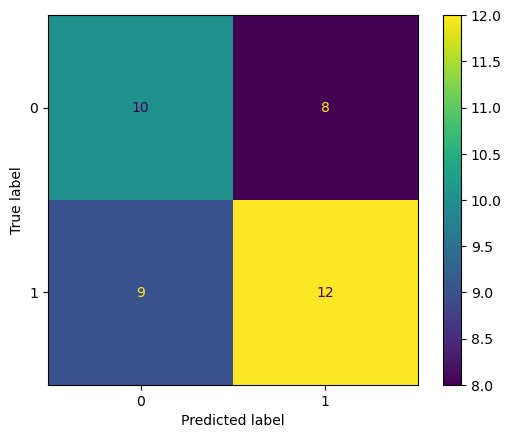

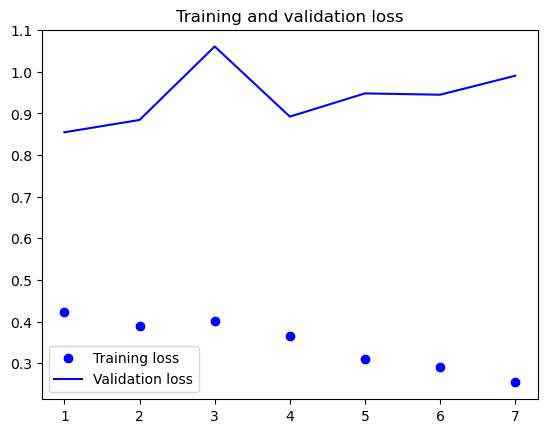

The ROP Model Classification Metrics:
Accuracy: 0.5384615384615384
Precision: 0.5384615384615384
Recall: 0.5384615384615384
F-Score: 0.5384615384615384
--------------------------------------------------------------


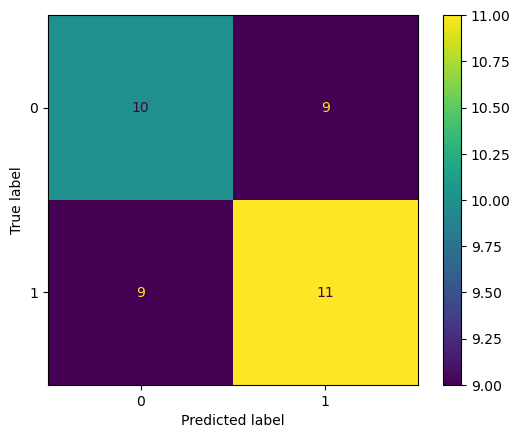

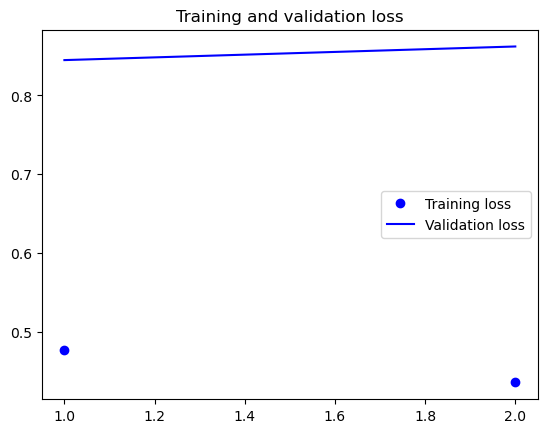

The XYL Model Classification Metrics:
Accuracy: 0.5641025641025641
Precision: 0.3659043659043659
Recall: 0.5641025641025641
F-Score: 0.44388398486759145
--------------------------------------------------------------


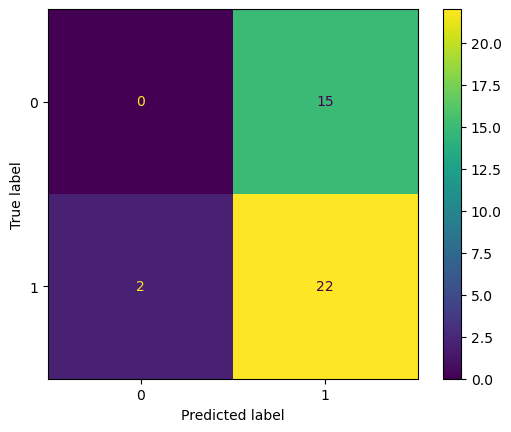

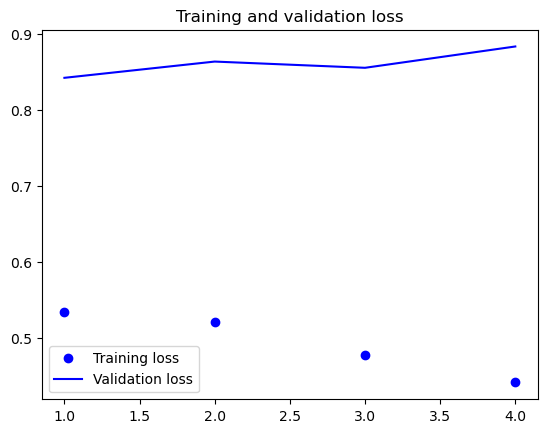

The CPAY Model Classification Metrics:
Accuracy: 0.5897435897435898
Precision: 0.6388611388611388
Recall: 0.5897435897435898
F-Score: 0.5702341137123746
--------------------------------------------------------------


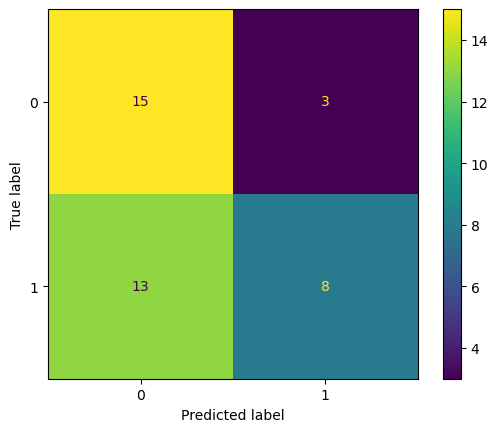

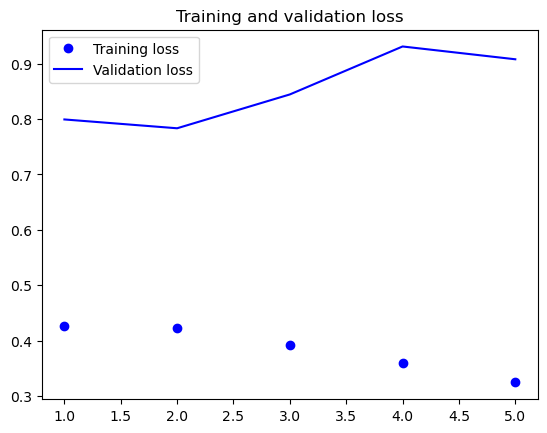

The INCY Model Classification Metrics:
Accuracy: 0.6666666666666666
Precision: 0.6693840579710145
Recall: 0.6666666666666666
F-Score: 0.6640088593576966
--------------------------------------------------------------


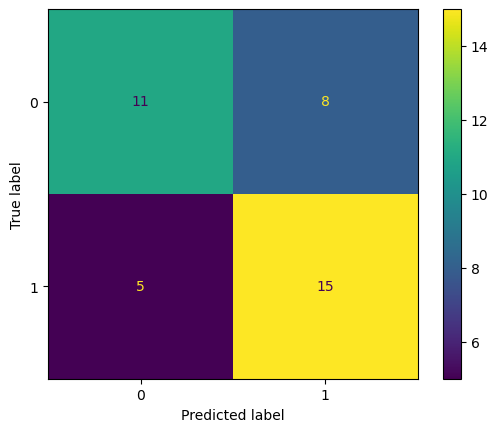

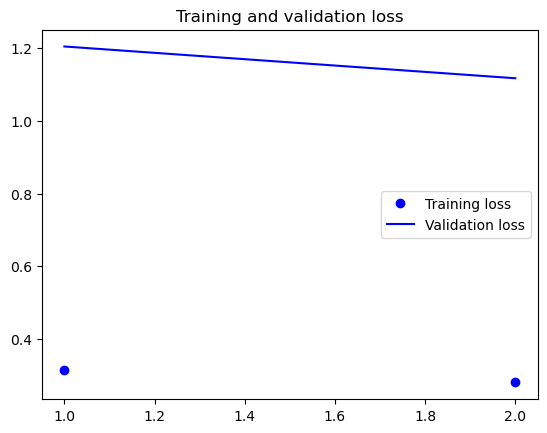

Average Classification Metrics for All Models:
Average Accuracy: 0.5846153846153845
Average Precision: 0.5557206008064133
Average Recall: 0.5846153846153845
Average F-Score: 0.5562531488006556


In [58]:
# evaluate the models in the archive
evaluate_models_archive(simpleRNN_models_archive)

## Classification vs Regression approach

As we stated before regression models could be more beneficial for predicting the actual future closing prices in the stock market since it would enable us to perform more advanced tasks such as portfolio optimization. Therefore before proceeding we will create a baseline regression model and compare it with our baseline classification model. If the regression model sounds promising, we will be improving it for the rest of the project, otherwise will proceed with the classification approach.

In [93]:
# apply the 3 steps of preparing data for training on each dataframe in the dictionary
target = 'regression' # set the target
timesteps = 10 # set the timesteps
data_sets_reg = prepare_data_to_train(full_dfs.copy(), min_max_scaler, target, timesteps)

# set the model initialization inputs
X_train_shape = data_sets_reg['PFE']['X_train'].shape
model_type='regression'
layer_type='SimpleRNN'

# create the model
simpleRNN_model_reg = RNNModel(X_train_shape, model_type, layer_type)
simpleRNN_model_reg = simpleRNN_model_reg.build()

# create models archive for simpleRNN classification approach
simpleRNN_models_reg_archive = create_models_archive(simpleRNN_model_reg, 
                                                 data_sets_reg, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='simpleRNN_reg', 
                                                 _project_name='proj')

Best epoch: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
training for the PFE model was done in: 0:00:06.155480
Best epoch: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training for the ROP model was done in: 0:00:10.152659
Best epoch: 7
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
training for the XYL model was done in: 0:00:11.456948
Best epoch: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training for the CPAY model was done in: 0:00:15.420977
Best epoch: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
training for the INCY model was done in: 0:00:19.379442


In [94]:
### evaluate the model
# get the mean absolute error
mae = simpleRNN_models_reg_archive['PFE']['model'].evaluate(data_sets_reg['PFE']['X_test'], data_sets_reg['PFE']['y_test'])[1]

# devide the mae by the average next_closing price
mae/data_sets_reg['PFE']['y_test'].mean()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.0385 - mae: 4.3423  


0.15135417410634744

The model's predictions are, on average, 15% off, which is significant for stock prediction. Hence, the regression approach is unsuitable with the current data, and we should focus on the classification approach.

## BatchNormalization

BatchNormalization is a tensorflow layer type that adaptively normalize data as the mean and variance changes while training. It helps with gradient propagation allowing for deeper networks.

We will add one BatchNormalization layer after each RNN layer and see if there are any improvements.

In [104]:
### create the baseline model
# source of inspiration: François Chollet (11, 2017), “Deep Learning with Python” chapter 6 [8]
# define a model class that allow us to build SimpleRNN, LSTM, or GRU models for classification or regression approches
class RNNModelNorm:
    def __init__(self, X_train_shape, model_type='classification', layer_type='SimpleRNN'):
        self.X_train_shape = X_train_shape
        self.model_type = model_type
        self.layer_type = layer_type

    def build(self):
        # initialize a sequential model
        model = Sequential()

        # add the model layers
        # input layer
        model.add(Input(shape=(self.X_train_shape[1], self.X_train_shape[2])))

        # RNN layers
        # set the layer type
        if self.layer_type == 'SimpleRNN':
            RNN_layer = SimpleRNN
        elif self.layer_type == 'LSTM':
            RNN_layer = LSTM
        elif self.layer_type == 'GRU':
            RNN_layer = GRU
        else:
            raise ValueError('Wrong layer type provided!!! only support (SimpleRNN, LSTM, GRU)')

        # add the selected layers to the model
        model.add(RNN_layer(64, return_sequences=True))
        model.add(BatchNormalization())
        model.add(RNN_layer(64, return_sequences=False))
        model.add(BatchNormalization())

        # set the model type and compile it
        if self.model_type == 'classification':
            model.add(Dense(2, activation='softmax')) # output layer
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compile the model
        elif self.model_type == 'regression':
            model.add(Dense(1)) # output layer
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) # compile the model
        else:
            raise ValueError('Wrong model type provided!!! only support (classification, regression)')

        return model

In [105]:
# set the model initialization inputs
X_train_shape = data_sets['PFE']['X_train'].shape
model_type='classification'
layer_type='SimpleRNN'

# create the model
simpleRNN_norm_model = RNNModelNorm(X_train_shape, model_type, layer_type)
simpleRNN_norm_model = simpleRNN_norm_model.build()

# create models archive for simpleRNN classification approach
simpleRNN_norm_models_archive = create_models_archive(simpleRNN_norm_model, 
                                                 data_sets, 
                                                 _model_type=model_type, 
                                                 _tuner=None, 
                                                 _epochs=50, 
                                                 _model_name='simpleRNN_norm_class', 
                                                 _project_name='proj')

Best epoch: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
training for the PFE model was done in: 0:00:03.813243
Best epoch: 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training for the ROP model was done in: 0:00:05.095529
Best epoch: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training for the XYL model was done in: 0:00:06.292234
Best epoch: 7
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training for the CPAY model was done in: 0:00:08.389190
Best epoch: 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training for the INCY model was done in: 0:00:09.716296


The PFE Model Classification Metrics:
Accuracy: 0.48717948717948717
Precision: 0.4778021978021978
Recall: 0.48717948717948717
F-Score: 0.4774247491638796
--------------------------------------------------------------


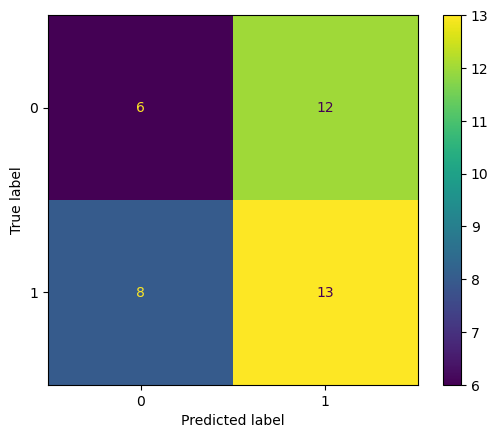

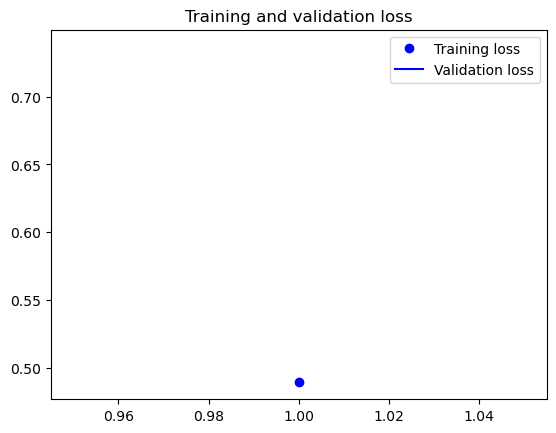

The ROP Model Classification Metrics:
Accuracy: 0.48717948717948717
Precision: 0.4909781576448242
Recall: 0.48717948717948717
F-Score: 0.46767001114827206
--------------------------------------------------------------


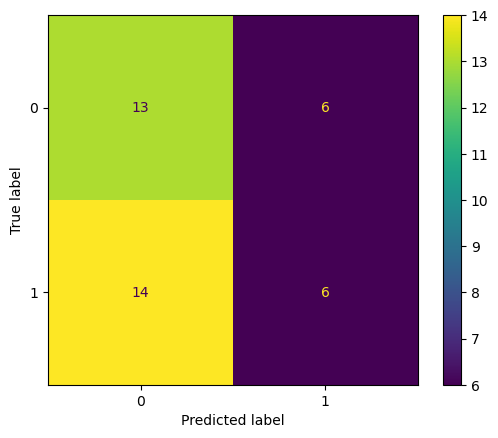

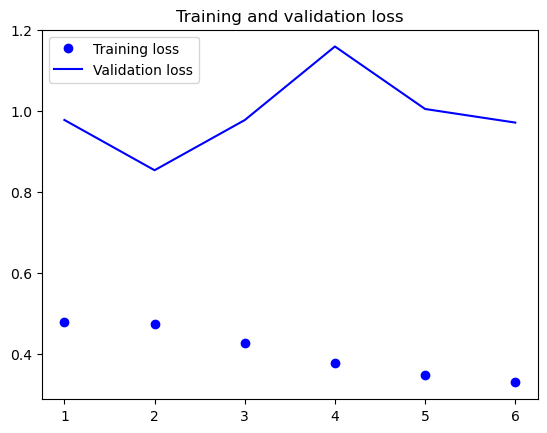

The XYL Model Classification Metrics:
Accuracy: 0.5641025641025641
Precision: 0.46538461538461534
Recall: 0.5641025641025641
F-Score: 0.47855623413161325
--------------------------------------------------------------


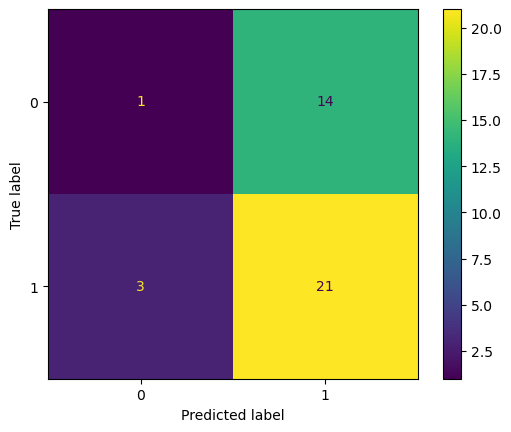

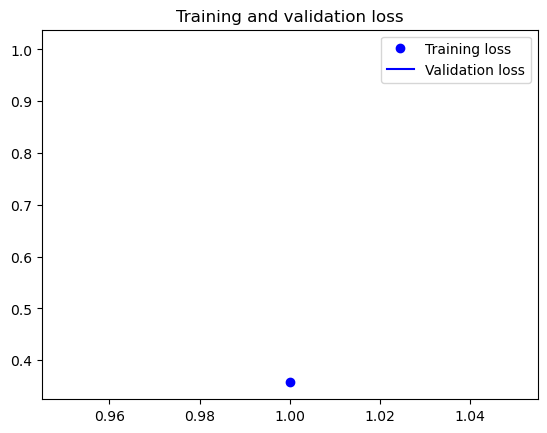

The CPAY Model Classification Metrics:
Accuracy: 0.48717948717948717
Precision: 0.48717948717948717
Recall: 0.48717948717948717
F-Score: 0.48717948717948717
--------------------------------------------------------------


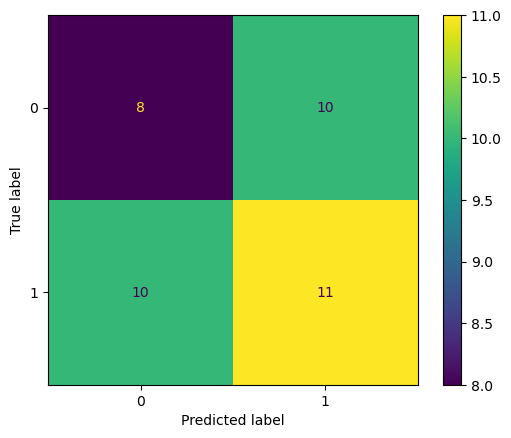

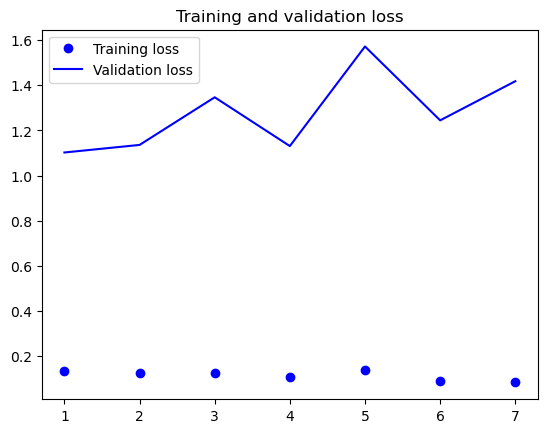

The INCY Model Classification Metrics:
Accuracy: 0.5128205128205128
Precision: 0.26298487836949375
Recall: 0.5128205128205128
F-Score: 0.3476749239461104
--------------------------------------------------------------


C:\Users\ammaroAsus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


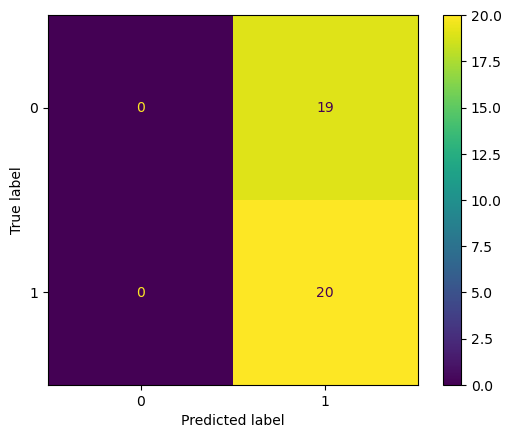

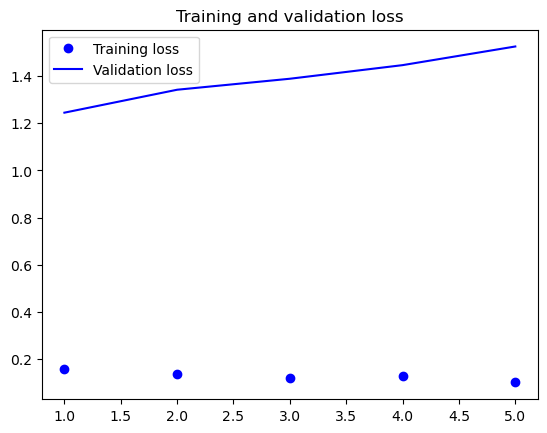

Average Classification Metrics for All Models:
Average Accuracy: 0.5076923076923077
Average Precision: 0.4368658672761237
Average Recall: 0.5076923076923077
Average F-Score: 0.4517010811138725


In [106]:
# evaluate the models in the archive
evaluate_models_archive(simpleRNN_norm_models_archive)

On average we see worst performance.

## hyperparameter optimization

## Inception Model

## Different data intervals 